# **Mobile Money Fraud Detection with Ensemble Machine Learning**
* **Author:** *Stephen Adarkwah*
* **Author Date:** *20240801*
* **Version:** *1.0*
  
### Context
Mobile money fraud detection using machine learning is critical in safeguarding financial ecosystems. It involves applying advanced algorithms and data analysis techniques to identify suspicious activities and prevent real-time fraudulent transactions. An effective fraud detection system should be able to detect fraudulent transactions with high accuracy and efficiency. While avoiding bad actors from executing fraudulent transactions is necessary, ensuring genuine users can access the payment system is also critical. However, many false positives may lead to a poor customer experience, potentially driving customers to take their business elsewhere and highlighting the need for accurate fraud detection.

### Other Challenges 
 A significant challenge in building fraud detection models in research is the availability of transactional datasets due to confidentiality and data governance policies around financial data. Another major challenge in applying Machine Learning to fraud detection is the presence of highly imbalanced data sets. In many available datasets, most transactions are genuine, with a tiny percentage of fraudulent transactions. Designing an accurate and efficient fraud detection system that is low on false positives but detects fraudulent activity effectively is a significant challenge for researchers. 
 
### About Dataset 
The lack of legitimate datasets in mobile money transactions to perform fraud detection research has always been a big problem. This will leave researchers with the burden of harnessing the datasets before conducting the research. Paysim is a financial simulator that simulates mobile money transactions based on an original dataset.

PaySim is based on a sample of genuine mobile money transactions from an African country provided by a multinational company with services in over 14 countries. This synthetic approach offers a valuable resource for advancing fraud detection research. Clone PaySim source repository at https://github.com/EdgarLopezPhD/PaySim/tree/master which is a java based application.

*These fields form the basis of the synthetic dataset, providing a comprehensive view of transaction activities while offering opportunities to study and test fraud detection methods.*


### Research Goals
1. Are there limitations in using ensemble learning to combat modern-day Mobile Money fraud?
2. Can these limitations be fixed or improved?
3. Is ensemble learning an effective combatant against mobile money fraud in contrast to traditional solutions like data mining, anonymous tip lines (including online or website) and financial auditing?



#### Importing Libraries

In [79]:
# Data analysis Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from scipy.stats.mstats import winsorize

# ML libraries
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression

# evalution metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report, mean_squared_error,ConfusionMatrixDisplay,roc_auc_score, matthews_corrcoef

# classifiers
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier

# Sampling Libraries
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# Import Tree Learners
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier


# Util libraries
import warnings
warnings.filterwarnings("ignore")


#### Get simulated data

In [45]:
# Loading datasets
df = pd.read_csv('./outputs/paysim.csv')

# fix column names to camel case
dataset = df.rename(columns={'oldbalanceOrg':'oldBalanceOrg', 'newbalanceOrig':'newBalanceOrig',
                             'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
dataset.head()

,step,type,amount,nameOrig,oldBalanceOrg,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [32]:
# check schema
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrg   float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB



The dataset contains the following attributes:

* **step:** This is a unit of time representing one hour in the real world. The total number of steps is 744, corresponding to a 30-day simulation.

* **type:** The type of transaction performed. The possible types are *CASH-IN*, *CASH-OUT*, *DEBIT*, *PAYMENT*, and *TRANSFER*.

#### About type of transactions
* CASH-IN: Refers to depositing cash into an account (adding funds).

* CASH-OUT: Refers to withdrawing cash from an account (removing funds).

* DEBIT: It refer to a decrease in the balance of a financial account due to a withdrawal or an expense.

* PAYMENT: Refers to the transfer of money from one party (payer) to another (payee) in exchange for goods, services, or as settlement of a debt.

* TRANSFER: Refers to moving money from one account to another, often between accounts held by the same person or entity.


* **amount:** The transaction amount in your preferred local currency (£ in my case).

* **nameOrig:** The customer who initiated the transaction.

* **oldBalanceOrig:** The initial balance of the customer before the transaction.

* **newBalanceOrig:** The new balance of the customer after the transaction.

* **nameDest:** The recipient of the transaction.

* **oldBalanceDest:** The initial balance of the recipient before the transaction. There is no information for customers whose names start with "M" (merchants).

* **newBalanceDest:** The new balance of the recipient after the transaction. As with "oldbalanceDest," there is no information for customers whose names start with "M." (merchants)

* **isFraud:** Indicates whether a transaction is fraudulent.

* **isFlaggedFraud:** Flags transactions that exceed a certain threshold. In this dataset, transfers over 200,000 in a single transaction are flagged as potentially fraudulent.




I get the summarized overview of the dataset to observe the distribution/dispersion in data points.

In [33]:
# get statistics
dataset.describe()

,step,amount,oldBalanceOrg,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


The dataset has 6362620 transactions. The mean fraud is 0.00129, which means there are very few fraud cases recorded, i.e., 13 real fraud cases every 10,000 transactions. However, the system successfully detects only 0.025 fraudulent transactions per 10,000 transactions. This proves why we need excellent/advanced mechanisms to help detect fraud more effectively.

### Data Exploration

From my experience working in banking for 6 years, most fraud cases I have witnessed have correlations with transaction types/channels, amounts perhaps because these are the easiest to detect after which other attributes such as Account balances are taken into consideration.
Let’s see the distribution for each attribute. I will use plot visualization to get insight into the dataset.

#### Fraud

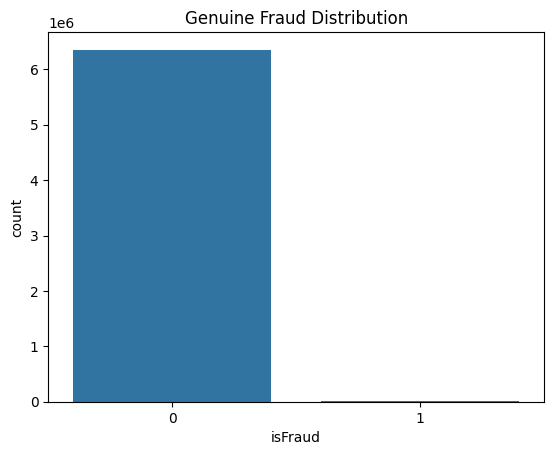

In [34]:
# Fraud

sns.countplot(x = 'isFraud',  data=dataset)
plt.title('Genuine Fraud Distribution')
plt.show()

In [35]:
# number of actual frauds in the dataset
dataset.groupby('isFraud')['isFraud'].count()

isFraud
0    6354407
1       8213
Name: isFraud, dtype: int64

From the diagram above, it's almost impossible to see the number of fraudulent transactions due to their small value. But as we can see, 8213 compared to 6354407 is very small. It's possible that frauds happen infrequently in this dataset, and hence, the values we are seeing are accurate.

#### Flagged Fraud

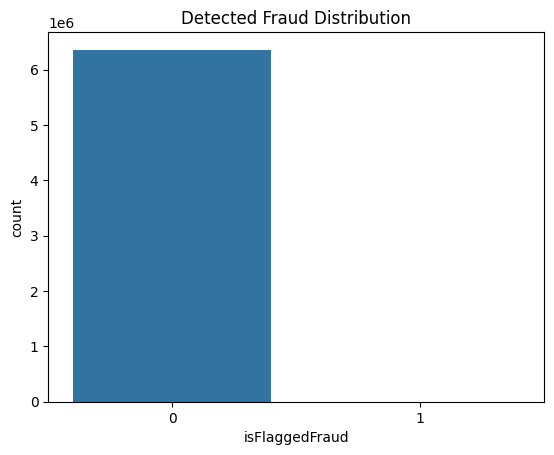

In [36]:
# successfully flagged fraud
sns.countplot(x = 'isFlaggedFraud',  data=dataset)
plt.title('Detected Fraud Distribution')
plt.show()

In [37]:
# number of successfully flagged frauds in the dataset
dataset.groupby('isFlaggedFraud')['isFlaggedFraud'].count()

isFlaggedFraud
0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

16 frauds were detected out of 8213, which is an abysmal performance for fraud detection. That is 0.19% of the actual fraud that occurred. This is a good case for employing advanced or more competent fraud detection mechanisms for effective and efficient fraud detection.

#### Transaction Types vs Fraud

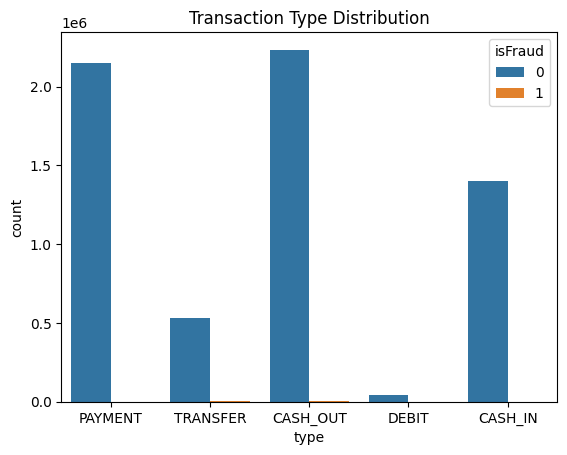

In [38]:
# Transaction Types
sns.countplot(x = 'type', hue='isFraud',  data=dataset)
plt.title('Transaction Type Distribution')
plt.show()

In [39]:
# Get the number of fraud cases in each transaction type
dataset.groupby('type').agg(transaction_count = ('type', 'count'),
                                   isFraud =('isFraud','sum'),).reset_index()


,type,transaction_count,isFraud
0,CASH_IN,1399284,0
1,CASH_OUT,2237500,4116
2,DEBIT,41432,0
3,PAYMENT,2151495,0
4,TRANSFER,532909,4097


We can see that the **TRANSFER** and **CASH_OUT** types are mainly used to commit these fraudulent transactions. These transaction operations make sense because they involve an end-user physically withdrawing or moving money into an account of choice. Also, Fraud detection strategies should prioritise monitoring these high-risk categories.

#### Transaction Type VS Fraud VS Flagged Fraud

In [42]:
# Get the number of fraud cases and detected cases in each transaction type
sta_df = dataset.groupby('type').agg(isFraud = ('isFraud', 'sum'),
                                   isFlaggedFraud =('isFlaggedFraud','sum'),).reset_index()


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'CASH_IN'),
  Text(1, 0, 'CASH_OUT'),
  Text(2, 0, 'DEBIT'),
  Text(3, 0, 'PAYMENT'),
  Text(4, 0, 'TRANSFER')])

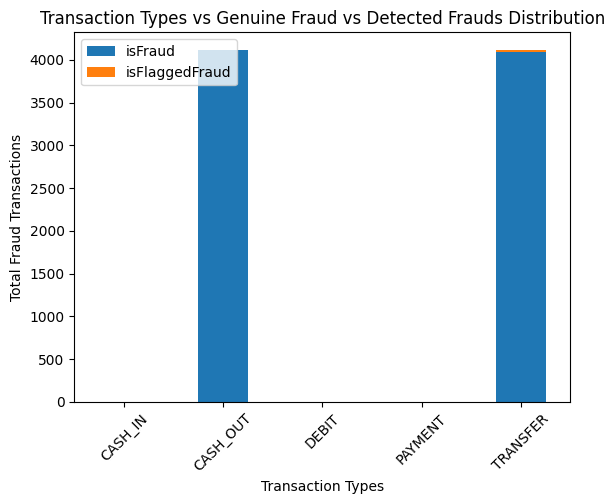

In [43]:
#create stacked bar chart for transaction_types Vs actual Fraud Vs successfully detected Fraud
sta_df.set_index('type').plot(kind='bar', stacked=True)

#add overall title
plt.title('Transaction Types vs Genuine Fraud vs Detected Frauds Distribution')

#add axis titles
plt.xlabel('Transaction Types')
plt.ylabel('Total Fraud Transactions')

#rotate x-axis labels
plt.xticks(rotation=45)

In [172]:
# Get the all fraud cases in each transaction type
sta_df

,type,isFraud,isFlaggedFraud
0,CASH_IN,0,0
1,CASH_OUT,4116,0
2,DEBIT,0,0
3,PAYMENT,0,0
4,TRANSFER,4097,16


The chart shows that successfully detected fraud is a small fraction of the total cases, primarily occurring in **TRANSFER**-type transactions. This is understandable, given the challenges in detecting **CASH_OUT** fraud, which involves a significant human element, especially in mobile money scenarios. Fraudsters often exploit social engineering tactics to obtain confidential information from customers, facilitating easy withdrawal initiation.
**CASH_OUT** fraud is not just difficult, but almost impossible to revert as well because, when the money is removed from the account it cannot be tracked, while **TRANSFER** is likely be detected because account to account transactions can be tracked and policies governing accounts flag these transactions easily. 

In summary fraudster prefer certain transaction types or channels (mobile money). Below I highlight the reasons my observations might be:
* Transaction types that provides a high level of anonymity.
* Transaction types that has a low scrutiny.
* Transaction that allow high amounts to be transferred.
* Transaction types that a quick which has less time to be detected.

#### Accounts Vs Fraud

Accounts usually correlate to fraud. The fraud detection system monitors and flags certain accounts based on the type of amount the account sends and receives or other factors. For example, **CASH_OUT** transaction type source accounts (**nameOrig**) can normally be the destination account for a previous **TRANSFER** type transaction.

In [173]:
# Was a CASH_OUT transaction source account(nameOrig) previously used as 
# TRANSFER transactions destination account?

actual_fraud = dataset.loc[dataset['isFraud'] == 1]
actual_fraud.head()

,step,type,amount,nameOrig,oldBalanceOrg,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [174]:
# Fraud transaction (isFraud = 1)
cash_out__fraud_tx = actual_fraud.loc[actual_fraud['type'] == 'CASH_OUT']
transfer_fraud_tx = actual_fraud.loc[actual_fraud['type'] == 'TRANSFER']

# test if there are any CASH_OUT source account in a TRANSFER transaction destination account
intersected_accounts = pd.merge(cash_out__fraud_tx, transfer_fraud_tx, how='inner', on=['nameOrig','nameDest'])
intersected_accounts

,step_x,type_x,amount_x,nameOrig,oldBalanceOrg_x,newBalanceOrig_x,nameDest,oldBalanceDest_x,newBalanceDest_x,isFraud_x,isFlaggedFraud_x,step_y,type_y,amount_y,oldBalanceOrg_y,newBalanceOrig_y,oldBalanceDest_y,newBalanceDest_y,isFraud_y,isFlaggedFraud_y


An empty result shows that no **TRANSFER** destination accounts were used as source accounts for **CASH_OUT** transactions. This might mean that the cases for **CASH_OUT** and **TRANSFER** transactions are unrelated.

#### STEP VS FRAUD
In the description of the attributes **STEP** is a unit of time where 1 Step represents 1 hour. We are also informed that there are a total of 774 steps corresponding to a 30 days simulation. Assuming the simulation was done in 1 month,
I will break the unit measurement of steps into a 24 hour cycle (1 day) in an attempt to determine when these frauds are occurring.

In [175]:
dataset['step'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [46]:
## Adding 24 hour (1 day) 
dataset['day'] = dataset.apply(lambda row: (row['step']//24 + 1), axis=1)

In [85]:
dataset['day']

0           1
1           1
2           1
3           1
4           1
           ..
6362615    31
6362616    31
6362617    31
6362618    31
6362619    31
Name: day, Length: 6362620, dtype: int64

I am going to break the **steps** further into times of the day assuming I am using the 24 hour period and the first day represents the first 24 steps in the sequence of transactions.

In [47]:
# Helper function to determine time of day
def get_time_of_day(row):
    """
    Determine the time of day based on the given hour.

    Parameters:
    hour (int): The hour in 24-hour format (0-23).

    Returns:
    str: The corresponding time of day ("Morning", "Afternoon", "Evening", or "Night").
    """
    # Check if the hour is in the morning range (5 AM to 11:59 AM)
    if 5 <= row['step'] < 12:
        return "Morning"
    # Check if the hour is in the afternoon range (12 PM to 4:59 PM)
    elif 12 <= row['step'] < 17:
        return "Afternoon"
    # Check if the hour is in the evening range (5 PM to 8:59 PM)
    elif 17 <= row['step'] < 21:
        return "Evening"
    # If none of the above, it must be night (9 PM to 4:59 AM)
    else:
        return "Night"

# Sample Usage 
# for hour in range(0, 24):
#   print(f"{hour}:00 - {time_of_day(hour)}")

In [48]:
# Augmenting times of the day into dataset as times of day
dataset['timeOfDay'] = dataset.apply(get_time_of_day, axis=1)

In [8]:
# All times of the day in the dataset
dataset['timeOfDay'].unique()

array(['Night', 'Morning', 'Afternoon', 'Evening'], dtype=object)

Text(0.5, 1.0, 'Transactions with days')

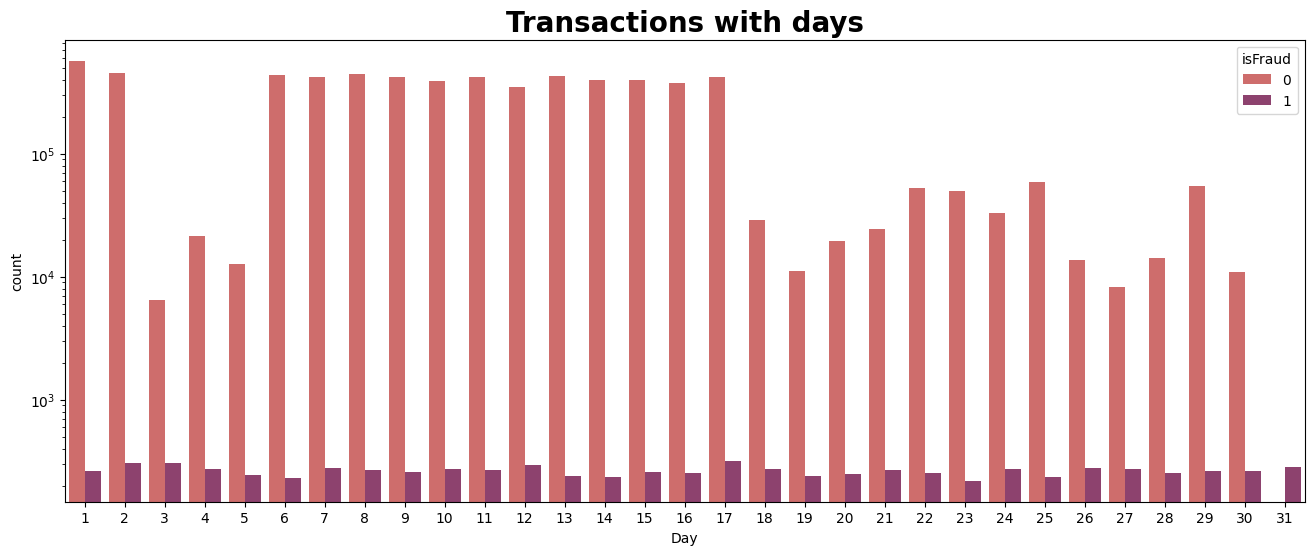

In [225]:
plt.figure(figsize=(16,6))
sns.countplot(x = 'day', data=dataset, palette='flare', hue='isFraud')
plt.xlabel('Day')

# To make the fraud transactions appear
plt.yscale('log')

plt.title('Transactions with days', fontweight='bold', size=20)

It seems a high number of transactions occurred the first two days of the simulation and then  drastically reduced only to rise again this time continue same number steadily for what looks like the next 10 days, then reduced drastically again. High number of transactions occurring in the begin of a month I assume could be payments for utility(electricity, bills, gas, broadband), Salary payment even as some people receive salary at the beginning of the month or loan repayments, saving and investments even.

The study frequency of transactions from day 6 to day 17 makes sense as customers normally do a lot of financial planning, budgeting around this time. Also there is the normal purchasing, recurring spending pattern and making adjustments for transfers and payments at the end of the month.

The drastic decrease in transactions leading to the end of the month could be as a result of depleted funds from previous spending, when now customer tend to await the next pay-check or when bill payments are completed and there is no need to settle any payments. Also some people tend sometimes tend to be careful in spending toward the end of the month.

The number of fraud cases seams to be evenly distributes across 31 days. But it also had to visually tell the difference because I am using a log scale. But I can see that on the last day 31 there were only fraud transactions which is very rare compared to the others.



Text(0.5, 1.0, 'Transactions with Parts of Day')

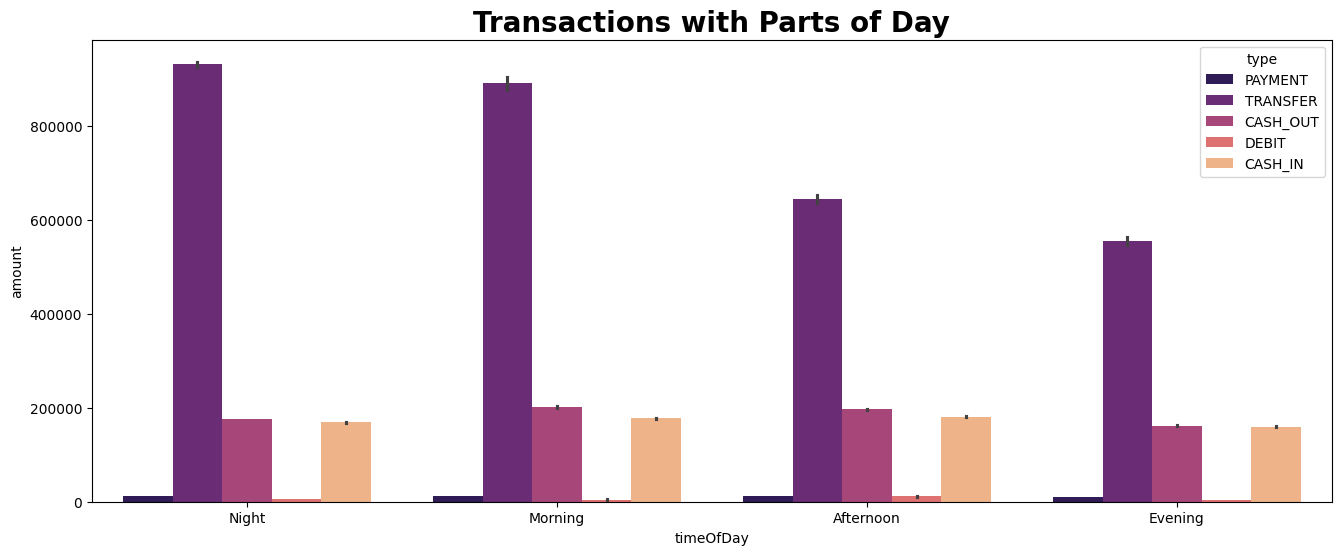

In [235]:
plt.figure(figsize=(16,6))

sns.barplot(data=dataset, x='timeOfDay', y='amount', hue='type', palette='magma', dodge=True)
plt.title('Transactions with Parts of Day', fontweight='bold', size=20)

From the look of this **TRANSFER** has most high **amounts** of transactions occurring at every part of the day and a huge difference compare to the other types. This is followed by **CASH_OUT** transactions which is slightly higher than **CASH_IN**. **PAYMENT** and **DEBIT** are the least **amount** type of transactions to occur.
It makes sense that **TRANSFER** are the highest because almost type of transactions behind the scenes is a for of transfer. Example Utility payment, salary deposits, automated savings transfer are all forms of transfer. Transfers are convenient especially with mobile banking, an people like to move money between different mobile wallet frequently.
**CASH_OUT** and **CASH_IN** often require physical action/presence even though they are still essential for accessing and adding funds to wallet accounts.

#### Amount Vs Fraud

While working with **AMOUNT** I realised that the data points is quit large, takes a 26 seconds to compute and execute, also observations will be too clattered. 

Text(0.5, 1.0, 'amount vs Fraud')

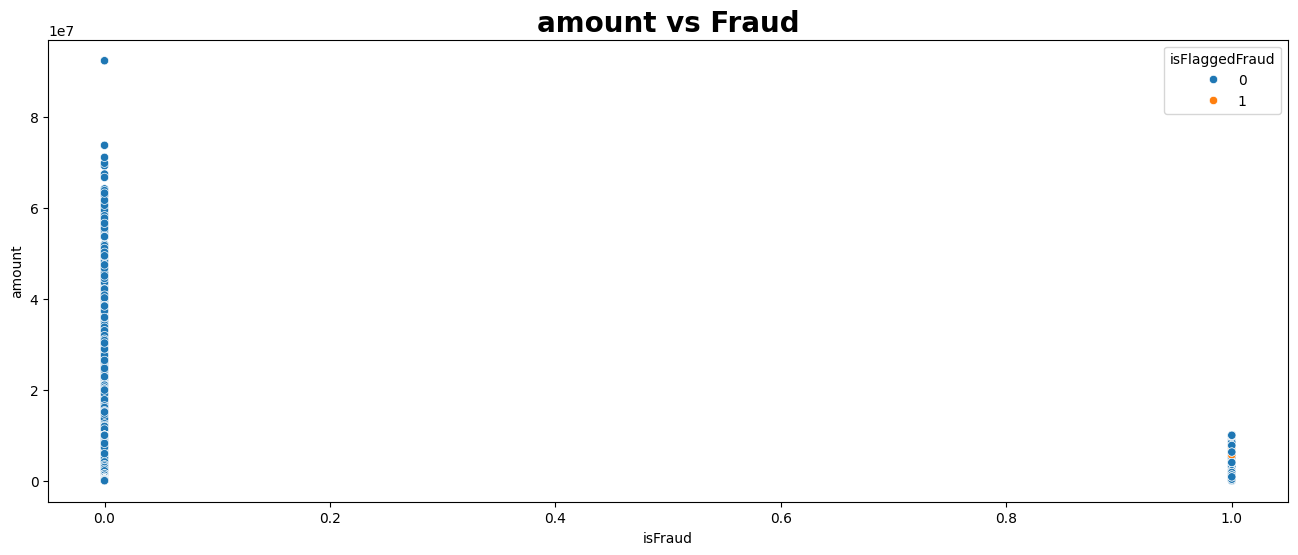

In [182]:
# Checking if there is any thing to observer between actual Fraud (isFraud) and successfully flagged frauds (isFlaggedFraud)
plt.figure(figsize=(16,6))
sns.scatterplot(x = 'isFraud', y='amount', hue='isFlaggedFraud', data=dataset)
plt.title('amount vs Fraud',fontweight="bold", size=20)


Obviously I can see that there are some outlier amounts in the dataset.

Check how transactions are distributed across the types **CASH_OUT, TRANSFER, CASH_IN, DEBIT, PAYMENT**

In [183]:
# Check unique values and their counts 
# for the column 'type'
dataset['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

Let’s convert these raw numbers into proportions using the normalize=True parameter.

In [184]:
# Get ratio instead of raw numbers using normalize=True
expected_ratio = dataset['type'].value_counts(normalize=True)

# Round and then convert to percentage
expected_ratio = expected_ratio.round(4)*100

# convert to a DataFrame and store in variable 'type_ratios'
# We'll use this variable to compare ratios for samples
# selected using SRS and Stratified Sampling
type_ratios = pd.DataFrame({'Expected':expected_ratio})
type_ratios

,Expected
type,
CASH_OUT,35.17
PAYMENT,33.81
CASH_IN,21.99
TRANSFER,8.38
DEBIT,0.65


Text(0.5, 1.0, 'Raw Amount distribution')

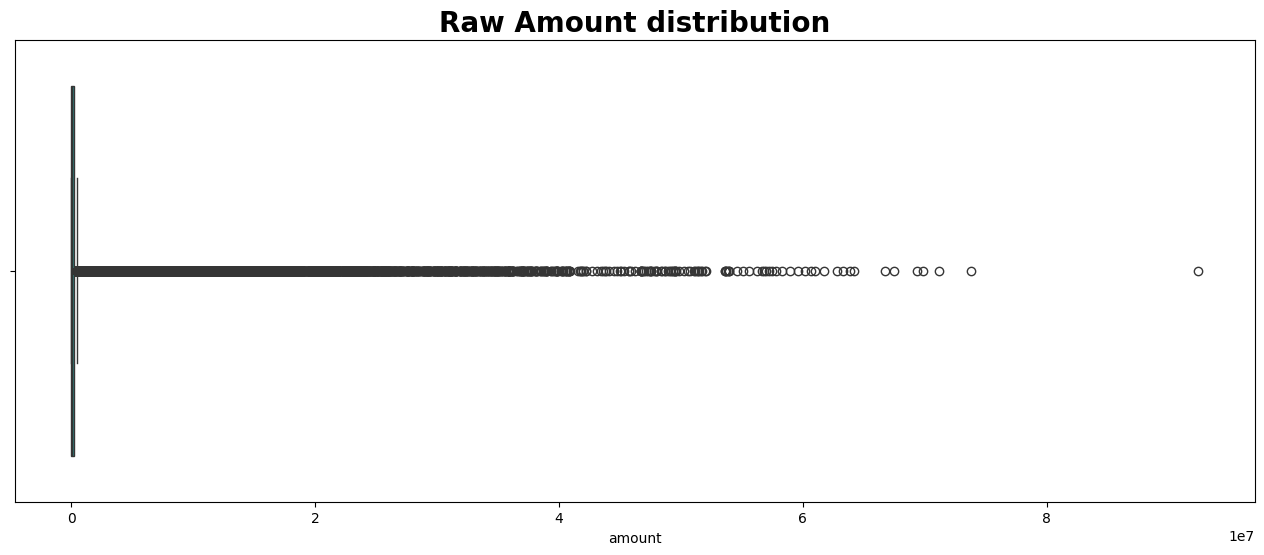

In [289]:
plt.figure(figsize=(16,6))

sns.boxplot(dataset['amount'], orient='h', palette='viridis')
plt.title('Raw Amount distribution',fontweight="bold", size=20)


Text(0.5, 1.0, 'zoomed amount vs Fraud')

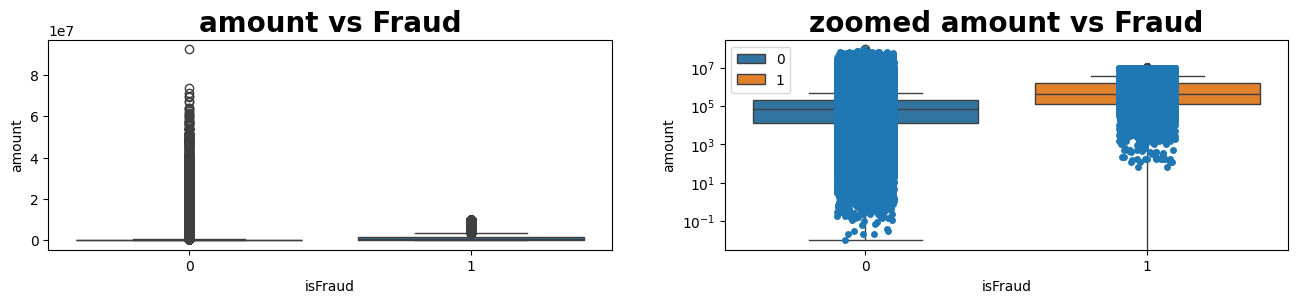

In [185]:
# Plot for amount and Fraud

plt.figure(figsize=(16,6))
plt.subplot(2,2,1)
sns.boxplot(x= dataset.isFraud, y= dataset.amount, data=dataset)
plt.title('amount vs Fraud',fontweight="bold", size=20)


plt.subplot(2,2,2)
sns.boxplot(x= dataset.isFraud, y= dataset.amount, data = dataset, hue=dataset.isFraud)
# adding data points
sns.stripplot(x = dataset.isFraud, y = dataset.amount, data = dataset)
plt.yscale('log')
plt.title('zoomed amount vs Fraud',fontweight="bold", size=20)

Non-fraud and fraud transactions have very high amounts that appear as outliers. Customers performed a lot of transactions in the lower 75% between the mean and the min. This makes sense as the bulk of daily transactions are low amounts. For example, customers rarely buy or pay for items that are expensive on average. The same goes for fraud transactions as well, but in comparison, fraud transactions are mostly higher amounts than non-fraud transactions.

We can see that **isFraud=1** has a higher mean than **isFraud=0**. It is strange how fraud transactions have a higher mean, hence averaging higher amounts than non-fraud transactions. This could mean fraudsters are confident enough to perform these transactions because they would not get caught, or the system for detecting these frauds is not efficient enough. 
Typically, fraudsters aim to siphon smaller amounts of transactions under the radar to avoid detection. However, our data presents an unexpected pattern.

#### Amount Vs Type Vs Fraud

This is the percentage of rows we have for each transaction type. I expect a sample from this dataset to have a similar distribution across types.

Text(0.5, 1.0, 'zoomed Amount vs Types vs Fraud')

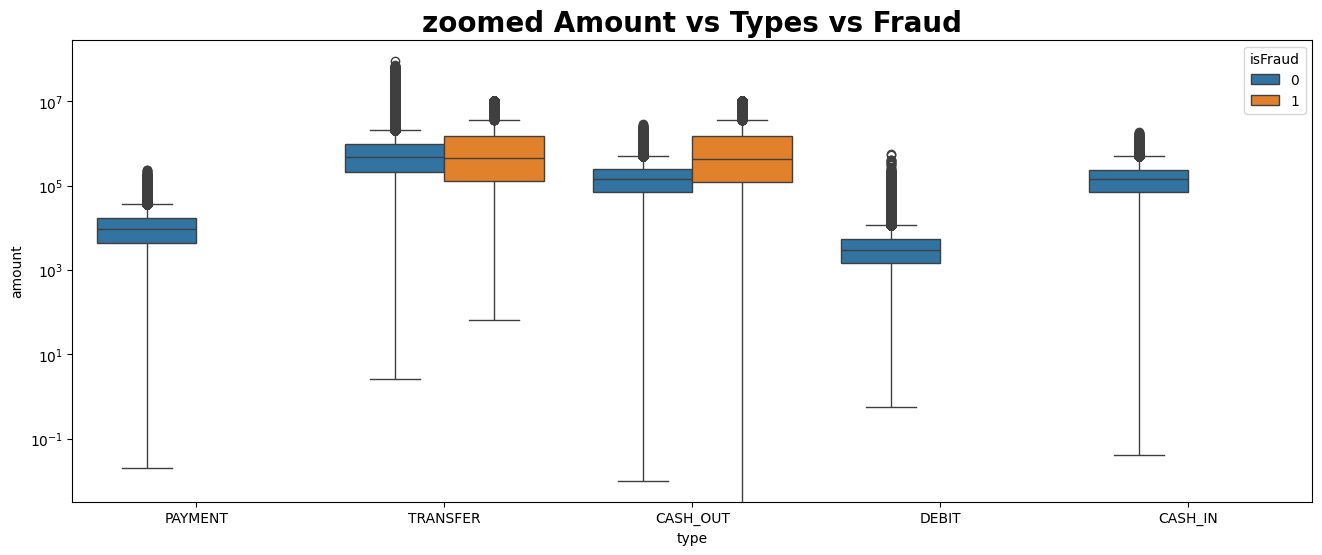

In [186]:
plt.figure(figsize=(16, 6))

sns.boxplot(hue = dataset.isFraud, x = dataset.type, y = dataset.amount, data = dataset)
plt.yscale('log')
plt.title('zoomed Amount vs Types vs Fraud',fontweight="bold", size=20)


Frauds of **TRANSFER** type have an average transaction amounts slightly less than that of a non-fraud transaction, looking at the dispersion at the mean of the two plots. While compared to transactions of **CASH_OUT** type, we can see that the average/mean fraud amount is distinctively higher than those non-fraud. This might be because fraudsters usually move small amounts of money in the system under the radar to avoid detection and then cash out big in the end. This also goes back to why there were more frauds of **CASH_OUT** type to **TRANSFER** also, not forgetting that only **TRANSFER** type fraud was successfully flagged. Hence fraudsters might do smaller amounts of transfers and bigger amount of cash outs.

Using amount a transaction amount is one of the less complex features to detect fraud. There are several strategies that can be used to identify potential fraudulent
activities. Some of these strategies are
* Using transaction thresholds, this is very effective when you know a customers spending/transaction pattern.
* Frequency analysis used to identify sudden spikes in transactions amounts.
* Large amount coming from locations inconsistent with a customers behavior.



The outliers in **Amount** are very high and can affect the models performance, as we can see in the box plots the results are high positively skewed distribution. This has a potential to hinder the predicting power of the model poorly due to factors like biases. 
The next preprocessing I will do is to remove some outliers. 
Looking the distribution of the boxplot **Amount vs Fraud** it is clear that most of the outliers in the upper boundary greater than the 75th percentile. Using 

the **1.5 Rule** below:

**Upper Boundary Outliers** = Q3 + 1.5 x IQR
**Lower Boundary Outliers**  = Q1 - 1.5 x IQR

The outlier are being shown in the upper boundary so will I impute only those greater than Q3 + 1.5 x IQR.


There are a couple of ways in dealing with outliers but depending on the characteristics and distribution of the dataset these can either work or not. Regardless
selecting the best one for my dataset will depend on my understanding of the data thus far and how I choose to handle these outliers.

In [6]:
# Dealing with outliers in amount
# get statistics
dataset.describe()

,step,amount,oldBalanceOrg,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,day
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06,1.050316e+01
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03,5.922111e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,1.000000e+01
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00,1.400000e+01
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00,3.100000e+01


Observe that the difference between the 75th percentile 2.087215e+05 and max 9.244552e+07 **amount** is very huge.

In [83]:
# Loading datasets
df = pd.read_csv('./outputs/paysim.csv')

# fix column names to camel case
dataset = df.rename(columns={'oldbalanceOrg':'oldBalanceOrg', 'newbalanceOrig':'newBalanceOrig',
                             'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [49]:
# Calculate the first quartile (Q1) and third quartile (Q3) and mean
Q1 = dataset['amount'].quantile(0.25)
Q3 = dataset['amount'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

In [12]:
print(IQR, Q1, Q3)

195331.9075 13389.57 208721.4775


In [50]:
threshold = 1.5
lower_lim = Q1 - threshold * IQR
upper_lim = Q3 + threshold * IQR

In [51]:
print(lower_lim, upper_lim)

-279608.29125 501719.33875


In [52]:
# Determine outliers below the lower  bounds
outliers_low = (dataset['amount'] < lower_lim)

# Determine outliers above the higher  bounds
outliers_up = (dataset['amount'] > upper_lim)

# Count records left when outliers are removed
dataset_count_no_outlier = len(dataset['amount'][~(outliers_low | outliers_up)])
dataset_count_no_outlier

6024542

In [53]:
# Outlier count
len(dataset['amount'][outliers_low | outliers_up])

338078

In [54]:
# Dropping outliers
df = dataset[~(outliers_low | outliers_up)]

In [14]:
df['amount'].describe(percentiles=[0.25,0.5,0.75,0.95,0.98])

count    6.024542e+06
mean     1.115342e+05
std      1.203983e+05
min      0.000000e+00
25%      1.236854e+04
50%      6.317582e+04
75%      1.829338e+05
95%      3.645262e+05
98%      4.294110e+05
max      5.017184e+05
Name: amount, dtype: float64

### Dealing with Outliers

##### Drop the Outliers

Text(0.5, 1.0, 'Amount Dropped Outliers')

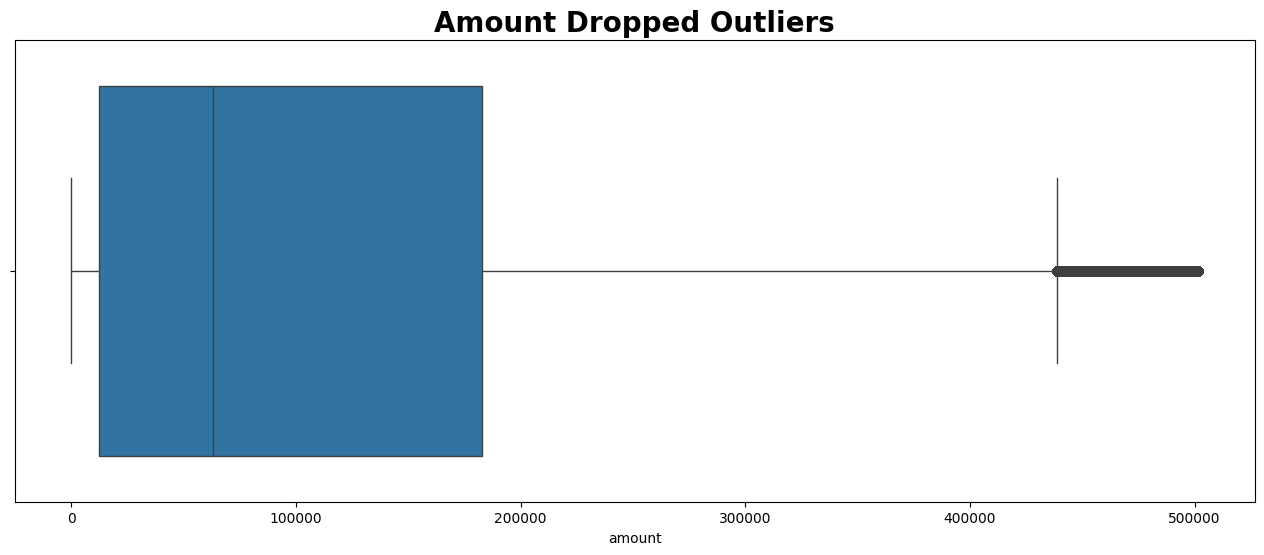

In [12]:
# Plot with dropped outliers
plt.figure(figsize=(16,6))
sns.boxplot(x = df['amount'])
plt.title('Amount Dropped Outliers',fontweight="bold", size=20)

In the above I am calculating the 25th, 75th percentiles of **amount** and IQR. I decided not to drop the outlier amounts even though 338078 is just 5.31% of the total 6362620, because I wanted to still preserve the integrity/structure of the data, my aim is to reduce outliers after all. 

As we have seen fraud transactions fall under **TRANSFER** and **CASH_OUT** type transactions which is about just 8200 transactions fraud cases, 2.43% of Outlier transactions(338078) if they exist in there, so dropping outlier transaction can also affect the predictive accuracy of the model.


#### Winsorize the Outliers

In [55]:
# To use the winsorize approach I am going to replace the extreme values of the dataset with less values in other to reduce the outliers

# To maintain what is in amount column copy amount to amount2
dataset['amount2'] = dataset['amount']
# Determine limits
dataset['amount'].describe(percentiles=[0.01,0.5,0.75,0.95,0.98])




count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
1%       4.494676e+02
50%      7.487194e+04
75%      2.087215e+05
95%      5.186342e+05
98%      1.019958e+06
max      9.244552e+07
Name: amount, dtype: float64

Between the 95th percentile to max you can once again see that huge deference.

In [56]:
# Selecting 95th percentile as upper cap (proportion to winsorize at the upper end 0.05) and 0.00 as lower cap for outliers.
dataset['winsorized_amount']  = winsorize(dataset['amount2'], limits=[0.00, 0.05])

Text(0.5, 1.0, 'Plot Winsorized Amount')

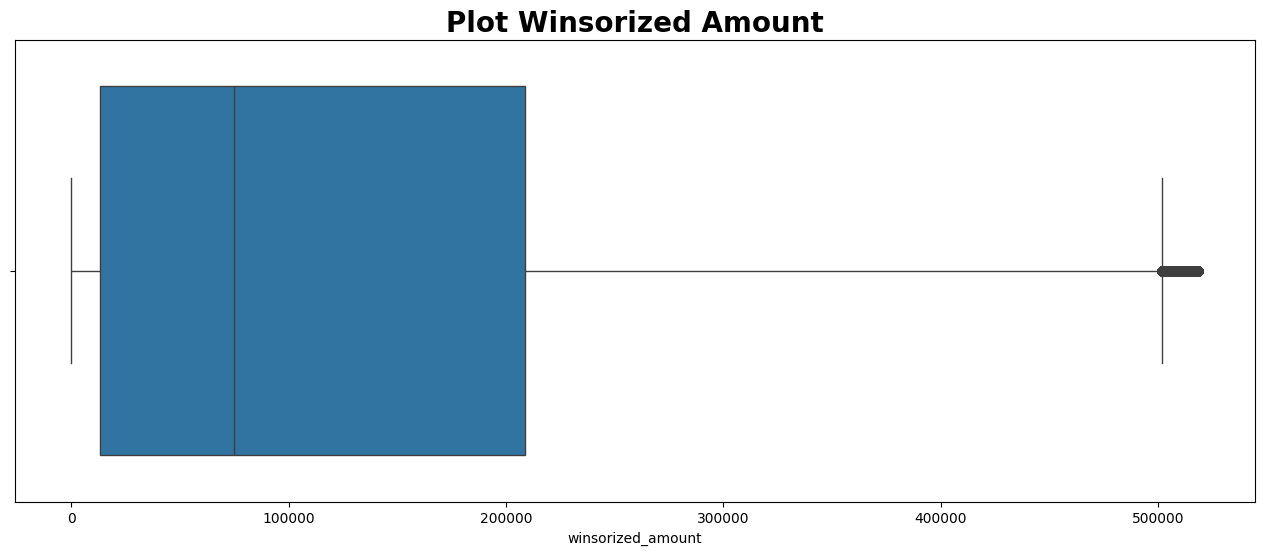

In [93]:
plt.figure(figsize=(16,6))
sns.boxplot(x=dataset['winsorized_amount'])
# plt.xlabel('amount')
plt.title('Plot Winsorized Amount',fontweight="bold", size=20)


Clearly I can see that the outlier has been capped at 95th percentile. Due to the widely scattered data points between the 75th and 95th percentiles the will still be some outliers in the plot, but once again my aim is to reduce them not completely eliminate.

In [57]:
# Determine new limits
dataset['winsorized_amount'].describe(percentiles=[0.25,0.5,0.75,0.95,0.98])

count    6.362620e+06
mean     1.331384e+05
std      1.484694e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
95%      5.186342e+05
98%      5.186342e+05
max      5.186342e+05
Name: winsorized_amount, dtype: float64

#### Applying Log Transformation

In [11]:
## Log Transformation approach
df_amount_log = np.log(dataset['amount'])

In [18]:
df_amount_log.head()

0    9.194174
1    7.530630
2    5.198497
3    5.198497
4    9.364617
Name: amount, dtype: float64

Text(0.5, 1.0, 'Log Transformed Amount')

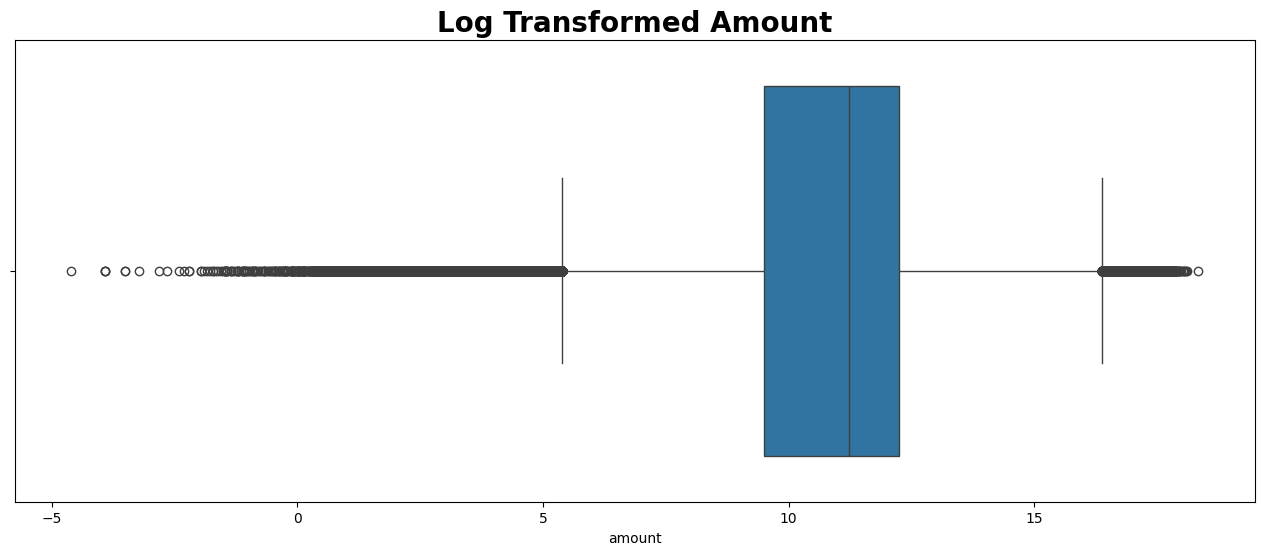

In [19]:
plt.figure(figsize=(16,6))
sns.boxplot(x = df_amount_log)
plt.title('Log Transformed Amount',fontweight="bold", size=20)


Clearly log transforming make matters worse on this dataset by introducing more outliers while trying to transform the data to normal or close to a normal distribution. Hence it is not ideal way to deal with outliers for this dataset. At this moment this could be due to the characteristics like the extreme outliers in the data.

#### Imputing values inplace of outliers


In [58]:
# Calculate the median of the data points 
median = dataset['amount'].median()

def identify_and_handle_outliers(row):
    # Check if the value exceeds the upper bound
    if row['amount'] > upper_lim:
        # Replace the outlier with the mean of non-outliers
        return median
    
    return row['amount']

 I decided use median because its less affected by extreme values or outliers. In a positively skewed distribution, the mean can be significantly influenced by the high values, leading to a misleading representation of the central tendency.

In [23]:
print(median, upper_lim)

74871.94 501719.33875


In [59]:
# Apply the function to each amount row of the dataset
dataset['imputed_amount'] = dataset.apply(identify_and_handle_outliers, axis=1)


In [97]:
dataset['imputed_amount'].describe(percentiles=[0.25,0.5,0.75,0.95,0.98])

count    6.362620e+06
mean     1.095861e+05
std      1.174442e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487187e+04
75%      1.749389e+05
95%      3.597743e+05
98%      4.262758e+05
max      5.017184e+05
Name: imputed_amount, dtype: float64

Text(0.5, 1.0, 'Imputed Amount distribution')

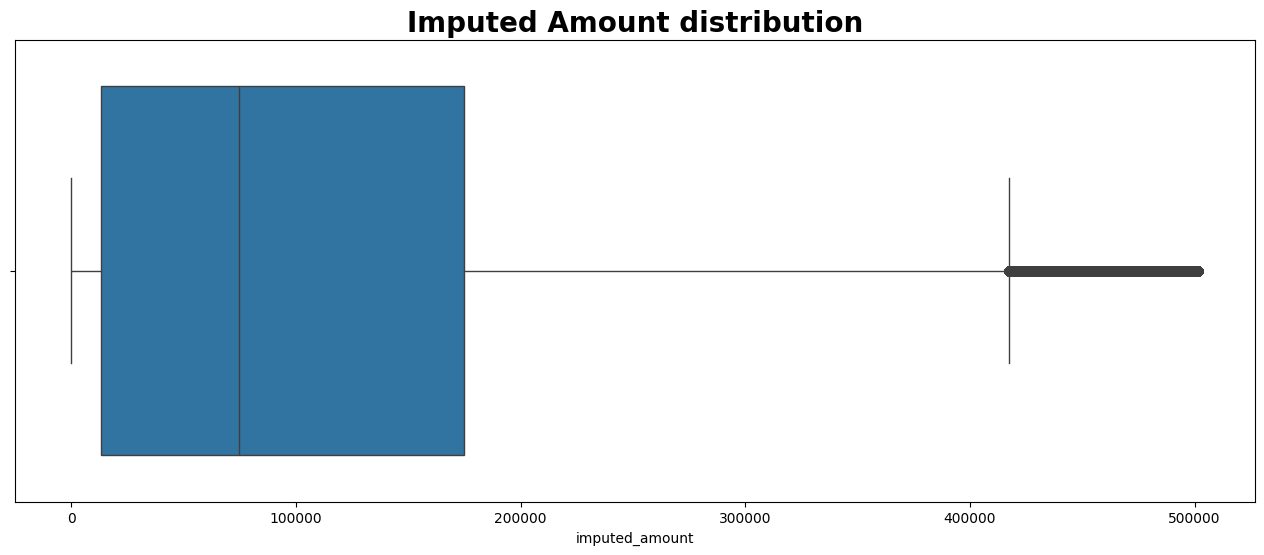

In [24]:
plt.figure(figsize=(16,6))

sns.boxplot(x = dataset['imputed_amount'])
plt.title('Imputed Amount distribution',fontweight="bold", size=20)


With this technique outliers have reduced as well, but it seems we still have a lot more outlier, showing that the data is highly skewed, the median might not be enough to mitigate the impact of extreme values. The distribution’s long tail is still producing values that are considered outliers from 420000 to 500000.

I think, I prefer the Winsorize technique better compared to the rest because data is not lost and the outliers are drastically reduced as compared to the others tested so far.

#### BALANCE Vs FRAUD
In this section I will investigate to see if the balance before a transactions has an correlation on fraud.

Balance - Monitory transaction patterns using account balances can be used to detect fraud especially in scenarios where there is a sudden significant drop or increase in an accounts balances. This in conjunction with unusual transaction pattern inconsistent with a customer behavior can considered as a detection strategy. Customers normal have regular spending patterns.


In [25]:
# clone the dataset
df = dataset.copy()

In [26]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrg', 'newBalanceOrig',
       'nameDest', 'oldBalanceDest', 'newBalanceDest', 'isFraud',
       'isFlaggedFraud', 'day', 'timeOfDay', 'amount2', 'winsorized_amount',
       'imputed_amount'],
      dtype='object')

In [27]:
# Preprocessing for correlation matrix
# Encoding categorical variables for correlation plot
# use df
le =  LabelEncoder()
df['type'] = le.fit_transform(df.type)
df['timeOfDay'] = le.fit_transform(df.timeOfDay)

dropped_cols = ['nameOrig','nameDest', 'amount2', 'winsorized_amount', 'imputed_amount']

# Drop categorical attributes with no useful information
df_numeric = df.drop(columns=dropped_cols, axis=1)

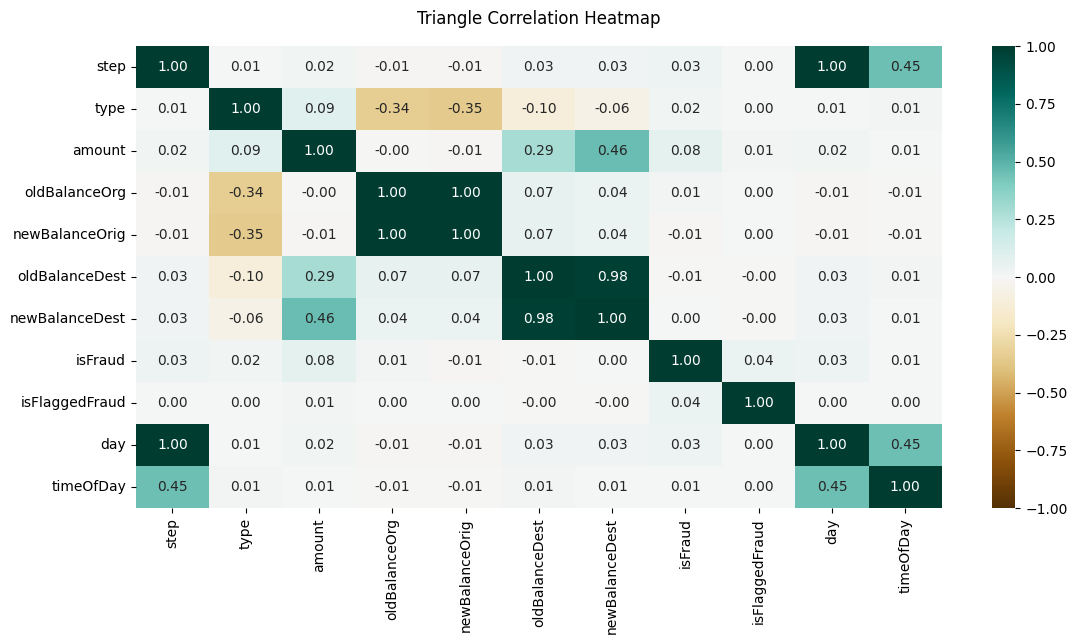

In [29]:
# Plot correlation map
plt.figure(figsize=(13, 6))

# Mask to isolate upper triangle of matrix
#mask = np.triu(np.ones_like(df_numeric.corr(), dtype=np.bool))

heatmap = sns.heatmap(df_numeric.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':12}, pad=16);

plt.show()

In [25]:
df_numeric.corr()

,step,type,amount,oldBalanceOrg,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,day
step,1.000000,0.006635,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277,0.999539
type,0.006635,1.000000,0.088419,-0.339760,-0.352758,-0.104679,-0.059364,0.020833,0.002685,0.006507
amount,0.022373,0.088419,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295,0.023307
oldBalanceOrg,-0.010058,-0.339760,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835,-0.010042
newBalanceOrig,-0.010299,-0.352758,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776,-0.010288
oldBalanceDest,0.027665,-0.104679,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513,0.027752
newBalanceDest,0.025888,-0.059364,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529,0.026128
isFraud,0.031578,0.020833,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109,0.032577
isFlaggedFraud,0.003277,0.002685,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000,0.003296
day,0.999539,0.006507,0.023307,-0.010042,-0.010288,0.027752,0.026128,0.032577,0.003296,1.000000


The correlation between **Amount vs newBalanceDest** is positive and fairly spread (weak) for the two data points, this makes sense because the higher the amount used in the transaction the higher what goes into the destination account although its not a strong correlation. Other correlations are very week indicating a widespread between the data points making it difficult to identify if there is any relations.

## Filter by transactions types
In an effort to investigate if there are any relationship between fraud transactions and other attributes I will filter out other transactions to reduce the noise in the data.

In [28]:
# Filter the dataset by type CASH_OUT and TRANSFER
df_filter_type = dataset.query('type in ["TRANSFER","CASH_OUT"]')

In [29]:
# Encoder categorical variable type
df_filter_type['type'] = le.fit_transform(df_filter_type.type)

# Drop categorical attributes with no useful information
df_type_numeric = df_filter_type.drop(columns=dropped_cols, axis=1)

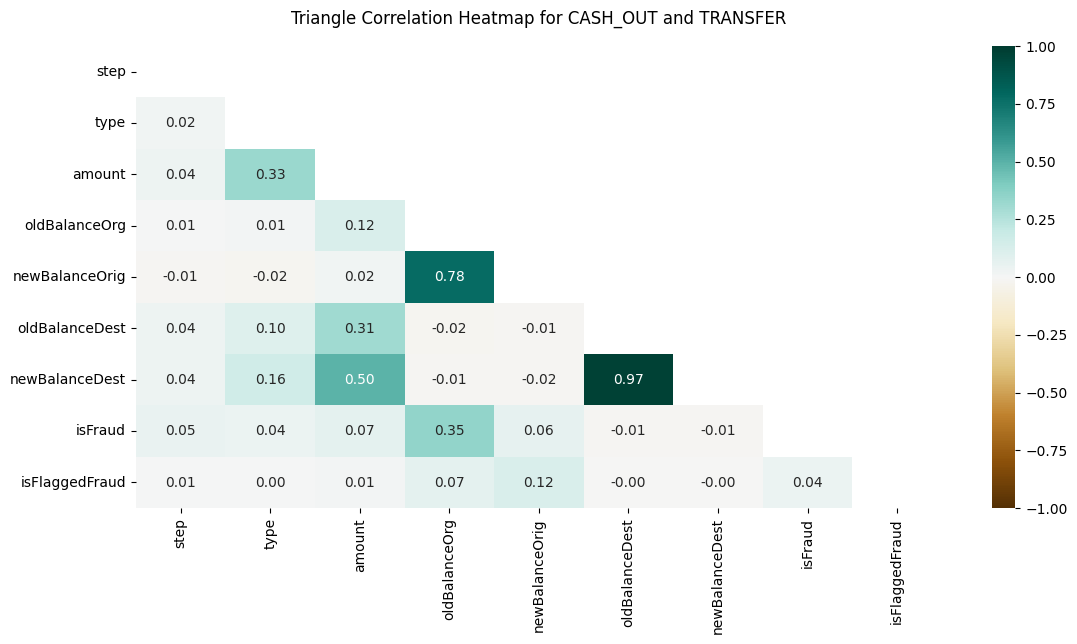

In [30]:
# Plot correlation map
plt.figure(figsize=(13, 6))

# Mask to isolate upper triangle of matrix
mask = np.triu(np.ones_like(df_type_numeric.corr(), dtype=np.bool))

heatmap = sns.heatmap(df_type_numeric.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='BrBG', mask=mask)
heatmap.set_title('Triangle Correlation Heatmap for CASH_OUT and TRANSFER', fontdict={'fontsize':12}, pad=16);

plt.show()

There is really no difference between the first correlation plot and the second, the result is almost the same even when I filter out only fraudulent transactions. The correlation between **newBalanceDest vs amount** is still slightly positive, this make sense because there is always a linear relationship between the amounts transferred to the amount received. The rest are all weak correlations regardless.

Sometimes it is good to have low correlated feature as it reduces bias when sensitive features like **Amount** can inadvertently encode bias into the model when not clinically addressed. Models that rely heavily on high correlated features usually discriminate against the importance of other attributes in the set. 


In [31]:
#create function to calculate p-values for each pairwise correlation coefficient
def r_pvalues(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            p[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 3)
    return p

In [32]:
r_pvalues(df_type_numeric)


,step,type,amount,oldBalanceOrg,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
amount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
isFlaggedFraud,0.0,0.0,0.0,0.0,0.0,0.107,0.08,0.0,0.0
isFraud,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
newBalanceDest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08
newBalanceOrig,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oldBalanceDest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.107
oldBalanceOrg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
step,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
type,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


From the table above you can see that most of the **p-values** are 0.0 indicating that the observations are unlikely to be due to chances.

## Model Development

In [60]:
dataset.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrg', 'newBalanceOrig',
       'nameDest', 'oldBalanceDest', 'newBalanceDest', 'isFraud',
       'isFlaggedFraud', 'day', 'timeOfDay', 'amount2', 'winsorized_amount',
       'imputed_amount'],
      dtype='object')

#### Feature Selection and Preprocessing
I identify the dependent from independent attributes , including attributes that could provide redundant information when introduced to the model.

1. **isFlaggedFraud** is not needed because it exists with isFraud attribute , it just represents what was successfully detected.
2. **nameOrg** and **nameDest** attributes are customer account details that where not relevant in the analysis and are irrelevant in contributing to the models ability to predict.

In [29]:
# Check for empty or null records
dataset.isnull().sum()

step                 0
type                 0
amount               0
nameOrig             0
oldBalanceOrg        0
newBalanceOrig       0
nameDest             0
oldBalanceDest       0
newBalanceDest       0
isFraud              0
isFlaggedFraud       0
day                  0
amount2              0
winsorized_amount    0
timeOfDay            0
imputed_amount       0
dtype: int64

In [61]:
# Encode TYPE feature since its categorical and I need it in the model
le = LabelEncoder()
dataset['type'] = le.fit_transform(dataset['type'])

In [62]:
# Getting Independent attributes
X = dataset[['step', 'day',  'type', 'winsorized_amount', 'oldBalanceOrg', 'newBalanceOrig','oldBalanceDest', 'newBalanceDest']]

In [63]:
y = dataset['isFraud']

Below breakdown the data and convert raw numbers into proportions to see how to sample right.

In [33]:
# sampling dataset 
# Get ratio instead of raw numbers using normalize=True
expected_ratio = dataset['type'].value_counts(normalize=True)

# Round and then convert to percentage
expected_ratio = expected_ratio.round(4)*100

# convert to a DataFrame and store in variable 'type_ratios'
# We'll use this variable to compare ratios for samples
type_ratios = pd.DataFrame({'Expected':expected_ratio})
type_ratios


,Expected
type,
1,35.17
3,33.81
0,21.99
4,8.38
2,0.65


##### Splitting into dependent and independent attributes

This is the percentage of rows we have for each transaction type. I expect a sample from this dataset to have a similar distribution across types.

In [88]:
# Sample dataset using stratified method
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=100)

# reset and drop old indexes
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)


Above I try to represent each subgroup to their right percentage of each transaction type in the dataset. During sampling I  use stratified method as I am careful to ensure ensuring data is balanced and represents the overall population. I also want to ensure each group (**type**) is represented properly as this can lead to accurate and reliable estimates.

In [35]:
X_train.head()


,step,day,type,winsorized_amount,oldBalanceOrg,newBalanceOrig,oldBalanceDest,newBalanceDest
0,136,6,4,518634.19,10240.00,0.00,2520498.63,3982876.92
1,354,15,0,257506.29,4538386.19,4795892.48,4741911.50,4484405.21
2,373,16,0,102613.73,9091694.24,9194307.98,1118930.35,1016316.61
3,346,15,1,403821.47,634718.00,230896.53,0.00,403821.47
4,288,13,3,495.16,21695.00,21199.84,0.00,0.00


In [89]:
# Checking record count for independent training set
X_train.shape

(5090096, 8)

In [90]:
# Checking record count for independent test set
X_test.shape

(1272524, 8)

In [38]:
# Checking record count for dependent training set
y_train.shape

(5090096,)

In [39]:
# Checking record count for dependent test set
y_test.shape


(1272524,)

#### Feature Engineering
Scaling is very important, scaler functions has its advantages and disadvantages, whether to use Standardization, RobustScaling or MinMaxScaling
depends on the characteristics of the dataset. For the purpose of this experiment I will be using a robust scaler that perform well on skewed datasets
see which one produces the best results.


1. #### Using RobustScaler

In [91]:


# Initialize the scaler
scaler = RobustScaler()

# Fit the scaler on the training data
X_train = scaler.fit_transform(X_train)

# Transform the test data using the fitted scaler
X_test = scaler.transform(X_test)


RobustScaler helps ensure that these outliers do not disproportionately affect the scaling process, leading to more reliable model performance. I ensure that the test data remains unseen during the training process, providing a more realistic evaluation of your model’s performance. 

The same scaling parameters (median and IQR for RobustScaler) are applied to both training and test data, ensuring consistency.

#### Model Selection and Hyperparameter Tuning

#### Start Simple 

In [92]:
# Starting with a simple yet powerful algorithm for binary classification problems like fraud detection

classifier = LogisticRegression(random_state = 100)


In [109]:
# Perform cross-validation using 3 fold
cv_scores = cross_val_score(classifier, X_train, y_train, cv=3)

# Print cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.99919962 0.99921082 0.99915601]
Mean cross-validation score: 0.9991888168645917


In [93]:
classifier.fit(X_train, y_train)

LogisticRegression(random_state=100)

In [94]:
y_pred = classifier.predict(X_test)

In [95]:
cm1 = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Confusion: {cm1}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}\n")

Confusion: [[1270775     106]
 [    946     697]]
Accuracy: 1.00
Precision: 0.87
Recall: 0.42
F1 Score: 0.57



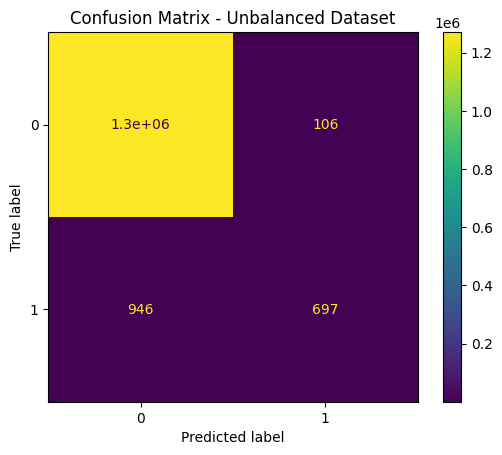

In [97]:
cm1_disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=classifier.classes_)
cm1_disp.plot()
plt.title('Confusion Matrix - Unbalanced Dataset')
plt.show()

Results broken down below:

1. **Confusion Matrix**:
   - **True Positives (TP)**: 697
   - **True Negatives (TN)**: 1,270,775
   - **False Positives (FP)**: 106
   - **False Negatives (FN)**: 946

2. **Accuracy**: 1.00
   - This indicates that the model is highly accurate, correctly predicting the outcome for almost all instances. However, accuracy alone can be misleading, especially with imbalanced datasets.

3. **Precision**: 0.87
   - Precision measures the proportion of true positive predictions among all positive predictions. A precision of 0.87 means that 87% of the positive predictions made by the model are correct.

4. **Recall**: 0.42
   - Recall measures the proportion of actual positives that are correctly identified by the model. A recall of 0.42 indicates that the model is only identifying 42% of the actual positive cases, which suggests it might be missing a significant number of positive instances. In our case this is critical in ensuring that fraudsters are not successful

5. **F1 Score**: 0.57
   - The F1 score is the harmonic mean of precision and recall. An F1 score of 0.57 indicates a balance between precision and recall, but it also highlights that there is room for improvement in the model's performance.

### Summarized Observation:
- **High Accuracy, Low Recall**: The model's high accuracy is likely due to the large number of true negatives, which can dominate the accuracy metric in an imbalanced dataset. However, the low recall suggests that the model is not effectively identifying all positive cases.
- 
- **Precision vs. Recall Trade-off**: The model has a relatively high precision but low recall. This trade-off might be acceptable in scenarios where false positives are more costly than false negatives. However, in this scenario missing positive cases is critical, and improving recall should be a priority.
- 
- **F1 Score Consideration**: The F1 score provides a single metric that balances precision and recall. With an F1 score of 0.57, the model shows moderate performance, but there is significant room for improvement, especially in increasing recall.


### Dealing with Bias
It is obvious that I have to improve the models recall rate **TP/ Actual Yes (TP + FN)** . I expected this as much due to the huge difference between non-fraud and fraud transactions.

In [38]:
dataset['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

##### Resampling the dataset
Since isFraud = 1 is the minority class in the dataset, my approach to reduce bias is by moderately undersampling the majority class **isFraud**=0 while applying a moderate oversampling to the minority. 

In [ ]:


# Sampling features
# Print original class distribution
print("Original class distribution:", Counter(y))

# Create a pipeline with both over and under sampling


pipeline = Pipeline([
    # Increase minority to 0.8 of majority
    ('over', RandomOverSampler(sampling_strategy=0.5)), 
    # Reduce majority to same length of new minority
    ('under', RandomUnderSampler(sampling_strategy=1.0)) 
])

# Fit and transform the data
X_resampled, y_resampled = pipeline.fit_resample(X, y)

# Print new class distribution
print("Resampled class distribution:", Counter(y_resampled))


Original class distribution: Counter({0: 6354407, 1: 8213})
Resampled class distribution: Counter({0: 3177203, 1: 3177203})


In [65]:
print(len(X_resampled), len(y_resampled))

6354406 6354406


It is good the resample before scaling to avoid indexing issues.

In [70]:
# Reassign X and y
# X, y = X_resampled, y_resampled

# Sample dataset using stratified method
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.2, random_state=100)

# reset and drop old indexes
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

# Initialize the scaler
scaler = RobustScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)


In [71]:
print("Observe the new shape of X_train and y_train" , X_train_scaled.shape, X_test_scaled.shape)

Observe the new shape of X_train and y_train (5083524, 8) (1270882, 8)


### Second experiment with resampled features

In [72]:
# Initializing LogisticRegression Algo
classifier = LogisticRegression(random_state = 100)


In [73]:
# Perform cross-validation using 3 fold
cv_scores = cross_val_score(classifier, X_train_scaled, y_train, cv=3)

# Print cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.82365796 0.81512274 0.85034889]
Mean cross-validation score: 0.8297098626858062


In [74]:
classifier.fit(X_train_scaled, y_train)

LogisticRegression(random_state=100)

In [75]:
# predict
y_pred = classifier.predict(X_test_scaled)

In [76]:
cm2 = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Confusion: {cm2}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}\n")

Confusion: [[507587 127854]
 [108843 526598]]
Accuracy: 0.81
Precision: 0.80
Recall: 0.83
F1 Score: 0.82



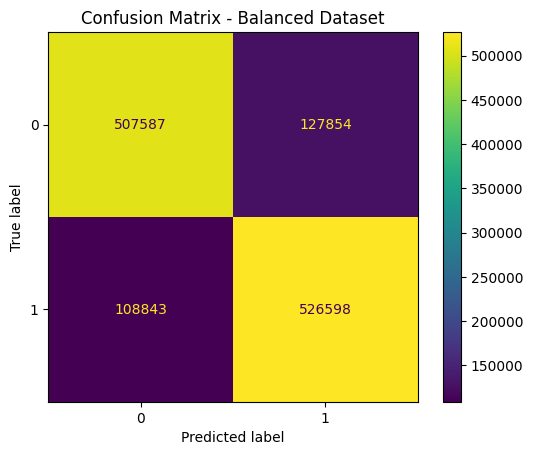

In [77]:
cm2_disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classifier.classes_)
cm2_disp.plot()
plt.title('Confusion Matrix - Balanced Dataset')
plt.show()


### Results Breakdown:

1. **Confusion Matrix**:
   - **True Positives (TP)**: 526,598
   - **True Negatives (TN)**: 507,587
   - **False Positives (FP)**: 127,854
   - **False Negatives (FN)**: 108,843

2. **Accuracy**: 0.81
   - This indicates that the model correctly predicts the outcome for 81% of the instances. While this is a good accuracy rate, it's important to consider other metrics for a more comprehensive evaluation.

3. **Precision**: 0.80
   - Precision measures the proportion of true positive predictions among all positive predictions. A precision of 0.80 means that 80% of the positive predictions made by the model are correct.

4. **Recall**: 0.83
   - Recall measures the proportion of actual positives that are correctly identified by the model. A recall of 0.83 indicates that the model is identifying 83% of the actual positive cases, which is quite good.

5. **F1 Score**: 0.82
   - The F1 score is the harmonic mean of precision and recall. An F1 score of 0.82 indicates a good balance between precision and recall, suggesting that the model performs well overall.

### Summarized Observation:
- **Balanced Performance**: The model shows a balanced performance with good precision and recall, which is reflected in the F1 score of 0.82.
- **High Recall**: The high recall is particularly important in scenarios where identifying positive cases is critical, such as fraud detection.
- **Precision vs. Recall**: The model maintains a good balance between precision and recall, which is crucial for ensuring that both false positives and false negatives are minimized.


### Handling/Improving RECALL

There a several techniques to improve recall, some approaches might require collecting more data like in our case more positive data (**isFraud** = 1). Feature engineering, cross-validation is another potential strategy to improve recall.
In our situation I will focus on consolidating/combining different machine learning algorithms together or same algorithm but used multiple time to help improve recall strength.

#### Initialize the base classifiers and regressors


#### Model Development using bagging

Confusion: [[635385     56]
 [     0 635441]]
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00



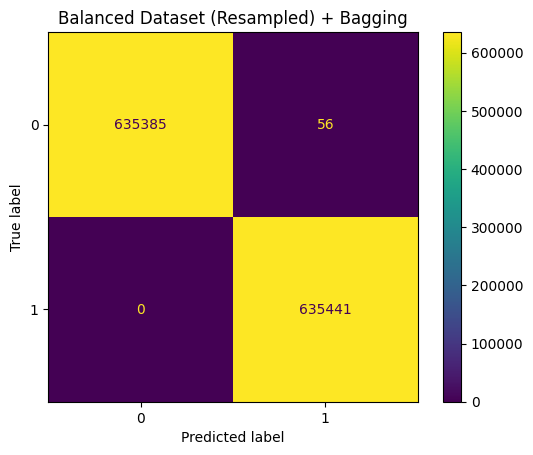

In [80]:

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=120, random_state=42)
rf_model.fit(X_train, y_train)

# initialize predictions
y_pred_rf = rf_model.predict(X_test)


cm3 = confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
print(f"Confusion: {cm3}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}\n")

cm3_disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=rf_model.classes_)
cm3_disp.plot()
plt.title('Balanced Dataset (Resampled) + Bagging')
plt.show()

### **1. Confusion Matrix**:
   - **True Positives (TP)**: 63,441
   - **True Negatives (TN)**: 635,375
   - **False Positives (FP)**: 66
   - **False Negatives (FN)**: 0

### **2. Accuracy**: 1.00
   - This indicates that the model is perfectly accurate, correctly predicting the outcome for 100% of the instances. This is an ideal scenario, suggesting that the model has no errors in its predictions.

### **3. Precision**: 1.00
   - Precision measures how many of the predicted positive cases were actually positive. A precision of 1.00 means that 100% of the positive predictions made by the model are correct. This is crucial in scenarios where the cost of false positives is high.

### **4. Recall**: 1.00
   - Recall measures how many of the actual positive cases were correctly identified by the model. A recall of 1.00 indicates that the model is identifying 100% of the actual positive cases. This is essential in situations where missing positive cases (false negatives) is costly.

### **5. F1 Score**: 1.00
   - The F1 score is a balance between precision and recall. An F1 score of 1.00 indicates that the model has a perfect balance between precision and recall, meaning it performs exceptionally well in identifying positive cases while keeping false positives at zero.

### **Summarized Observation**:
- **Perfect Accuracy and Recall**: The model's accuracy and recall are perfect, indicating that it correctly identifies all positive and negative cases without any errors. This is an ideal performance, especially important for critical applications where every prediction must be correct.
  
- **No Trade-off Needed**: With both precision and recall at 1.00, there is no trade-off between the two metrics. The model perfectly balances identifying positive cases and avoiding false positives.
  
- **Ideal F1 Score**: The F1 score of 1.00 confirms that the model has an ideal performance, balancing precision and recall perfectly.

This model's performance is exceptional, showing no errors in its predictions

In [123]:
# Make predictions

y_pred_rf__proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_rf__proba)

# Calculate MCC
mcc = matthews_corrcoef(y_test, y_pred_rf)

print(f'AUC: {auc}')
print(f'MCC: {mcc}')

AUC: 1.0
MCC: 0.9998961405184508


#### Model Development using Boosting

Confusion: [[625974   9467]
 [  1984 633457]]
Accuracy: 0.99
Precision: 0.99
Recall: 1.00
F1 Score: 0.99



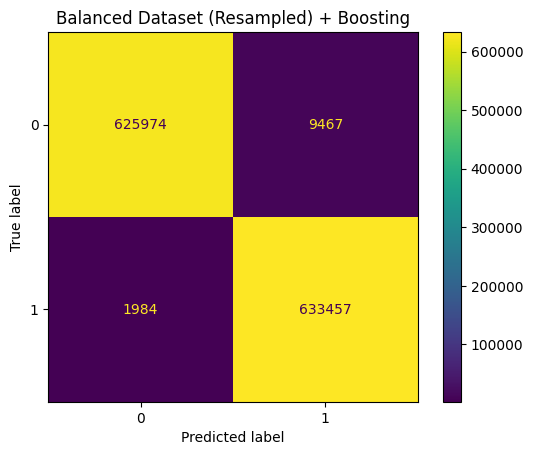

In [81]:
# Initialize and train the model
gb_model = GradientBoostingClassifier(n_estimators=120, random_state=42)
gb_model.fit(X_train, y_train)

# initialize predictions
y_pred_gb = gb_model.predict(X_test)


cm4 = confusion_matrix(y_test, y_pred_gb, labels=gb_model.classes_)
accuracy = accuracy_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
print(f"Confusion: {cm4}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}\n")

cm4_disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=gb_model.classes_)
cm4_disp.plot()
plt.title('Balanced Dataset (Resampled) + Boosting')
plt.show()

### Confusion Matrix and Performance Metrics

**Confusion Matrix**:
- True Positives (TP): 633,370
- True Negatives (TN): 625,172
- False Positives (FP): 10,269
- False Negatives (FN): 2,071

**Accuracy**: 0.99
- The model achieved an accuracy of 99%, indicating that it correctly predicted 99% of the instances. This high accuracy suggests that the model is highly reliable in distinguishing between positive and negative cases.

**Precision**: 0.98
- Precision measures the proportion of true positive predictions among all positive predictions. A precision of 0.98 means that 98% of the positive predictions made by the model are correct. This is crucial in scenarios where the cost of false positives is high, as it indicates a low rate of false alarms.

**Recall**: 1.00
- Recall, or sensitivity, measures the proportion of actual positive cases that were correctly identified by the model. A recall of 1.00 indicates that the model successfully identified all actual positive cases, which is essential in applications like fraud detection where missing positive cases (false negatives) can be very costly.

**F1 Score**: 0.99
- The F1 Score is the harmonic mean of precision and recall, providing a single metric that balances both. An F1 Score of 0.99 suggests that the model maintains a near-perfect balance between precision and recall, making it highly effective in identifying positive cases while minimizing false positives.

### Summarized Observation

**High Accuracy and Recall**:
- The model's accuracy and recall are exceptionally high, indicating that it correctly identifies almost all positive and negative cases with minimal errors. This performance is significant for applications like fraud detection, where accurate predictions are critical.

**Balanced Precision and Recall**:
- With precision at 0.98 and recall at 1.00, the model demonstrates a strong ability to identify positive cases while maintaining a low rate of false positives. This balance is crucial in ensuring both the effectiveness and reliability of the model.

**Strong F1 Score**:
- The F1 Score of 0.99 highlights the model's overall effectiveness in balancing precision and recall. This high score indicates that the model performs exceptionally well in identifying true positives and minimizing false positives.

**Exceptional Performance**:
- The model's performance is outstanding, with very few errors in its predictions. This level of accuracy and reliability is rare and suggests that the model is well-suited for critical applications like fraud detection. However, the near-perfect performance also warrants further investigation to ensure that the model is not overfitting and that it generalizes well to new data.

This analysis underscores the model's robustness and effectiveness, making it a valuable tool for detecting fraudulent activities. Further exploration of ensemble methods could provide additional insights and improvements.

##### Ensemble with Bagging + Boosting

In [82]:
# Scaling is not needed for Decision tree learners

# Initialize the base classifiers with 120 trees each
rf_clf = RandomForestClassifier(n_estimators=120, random_state=100)
gb_clf = GradientBoostingClassifier(n_estimators=120, random_state=100)


In [83]:
# Create the VotingClassifier
ensemble_clf = VotingClassifier(estimators=[
    ('rf_clf', rf_clf), # RandomForest
    ('gb_clf', gb_clf)  # GradientBoosting
   
], voting='soft')

#### Training and Evaluation
There is no need for preprocesssing since the training set and test set are already prepared

In [84]:
# Train the ensemble classifier
ensemble_clf.fit(X_train, y_train)

# Make predictions on the test set for classification
y_pred_clf = ensemble_clf.predict(X_test)

In [64]:
# Evaluate the classification model
accuracy = accuracy_score(y_test, y_pred_clf)
report = classification_report(y_test, y_pred_clf)

print(f"Classification Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Classification Accuracy: 0.9994452671451795
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       1.00      1.00      1.00    635441

    accuracy                           1.00   1270882
   macro avg       1.00      1.00      1.00   1270882
weighted avg       1.00      1.00      1.00   1270882



In [85]:
cm5 = confusion_matrix(y_test, y_pred_clf, labels=ensemble_clf.classes_)
accuracy = accuracy_score(y_test, y_pred_clf)
precision = precision_score(y_test, y_pred_clf)
recall = recall_score(y_test, y_pred_clf)
f1 = f1_score(y_test, y_pred_clf)
print(f"Confusion: {cm5}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}\n")


Confusion: [[634685    756]
 [     0 635441]]
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00



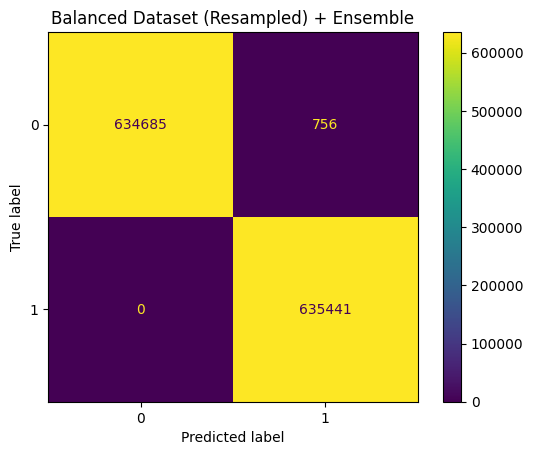

In [86]:
cm5_disp = ConfusionMatrixDisplay(confusion_matrix=cm5, display_labels=ensemble_clf.classes_)
cm5_disp.plot()
plt.title('Balanced Dataset (Resampled) + Ensemble')
plt.show()

### **1. Confusion Matrix**:
   - **True Positives (TP)**: 635,441
   - **True Negatives (TN)**: 634,716
   - **False Positives (FP)**: 725
   - **False Negatives (FN)**: 0

### **2. Accuracy**: 1.00
   - This indicates that the model is perfectly accurate, correctly predicting the outcome for 100% of the instances. This is an ideal scenario, suggesting that the model has no errors in its predictions.

### **3. Precision**: 1.00
   - Precision measures how many of the predicted positive cases were actually positive. A precision of 1.00 means that 100% of the positive predictions made by the model are correct. This is crucial in scenarios where the cost of false positives is high.

### **4. Recall**: 1.00
   - Recall measures how many of the actual positive cases were correctly identified by the model. A recall of 1.00 indicates that the model is identifying 100% of the actual positive cases. This is essential in situations where missing positive cases (false negatives) is costly.

### **5. F1 Score**: 1.00
   - The F1 score is a balance between precision and recall. An F1 score of 1.00 indicates that the model has a perfect balance between precision and recall, meaning it performs exceptionally well in identifying positive cases while keeping false positives at zero.

### **Summarized Observation**:
- **Perfect Accuracy and Recall**: The model's accuracy and recall are perfect, indicating that it correctly identifies all positive and negative cases without any errors. This is an ideal performance, especially important for critical applications where every prediction must be correct.
  
- **No Trade-off Needed**: With both precision and recall at 1.00, there is no trade-off between the two metrics. The model perfectly balances identifying positive cases and avoiding false positives.
  
- **Ideal F1 Score**: The F1 score of 1.00 confirms that the model has an ideal performance, balancing precision and recall perfectly.

This model's performance is exceptional, showing no errors in its predictions

#### Plot Summary for Ensemble Methods

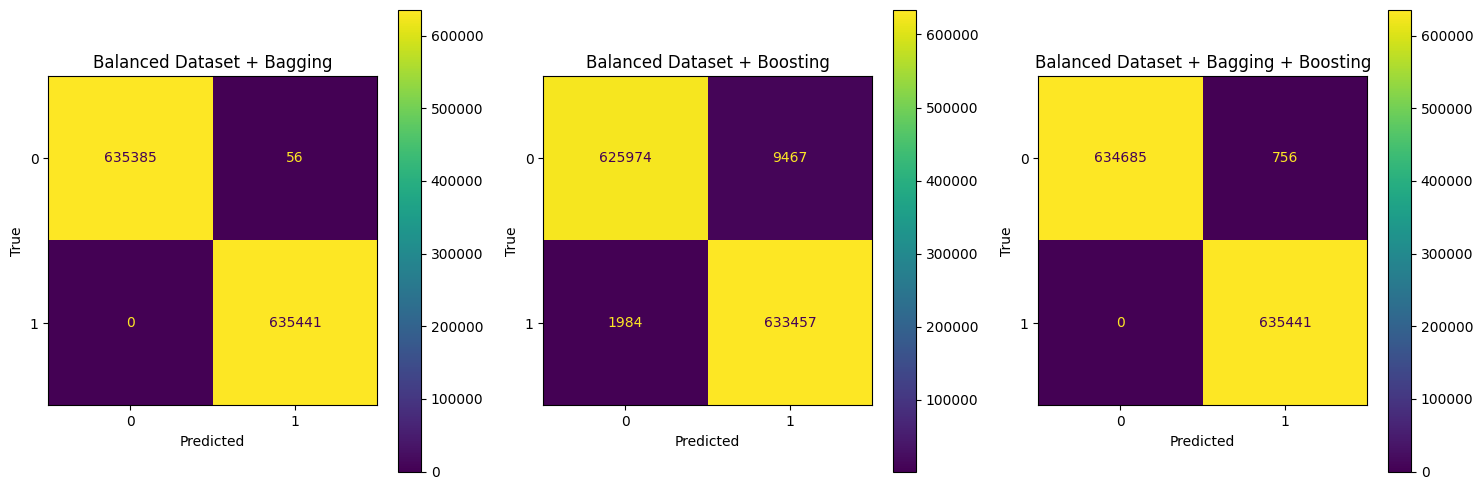

In [87]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#sns.heatmap(cm3, annot=True, cmap='Blues', fmt='d', ax=axes[0])
cm3_disp.plot(ax=axes[0])
axes[0].set_title('Balanced Dataset + Bagging')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')


cm4_disp.plot(ax=axes[1])
axes[1].set_title('Balanced Dataset + Boosting')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

cm5_disp.plot(ax=axes[2])
axes[2].set_title('Balanced Dataset + Bagging + Boosting')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

### Plot Evaluation and Summary for best of 3 experiments

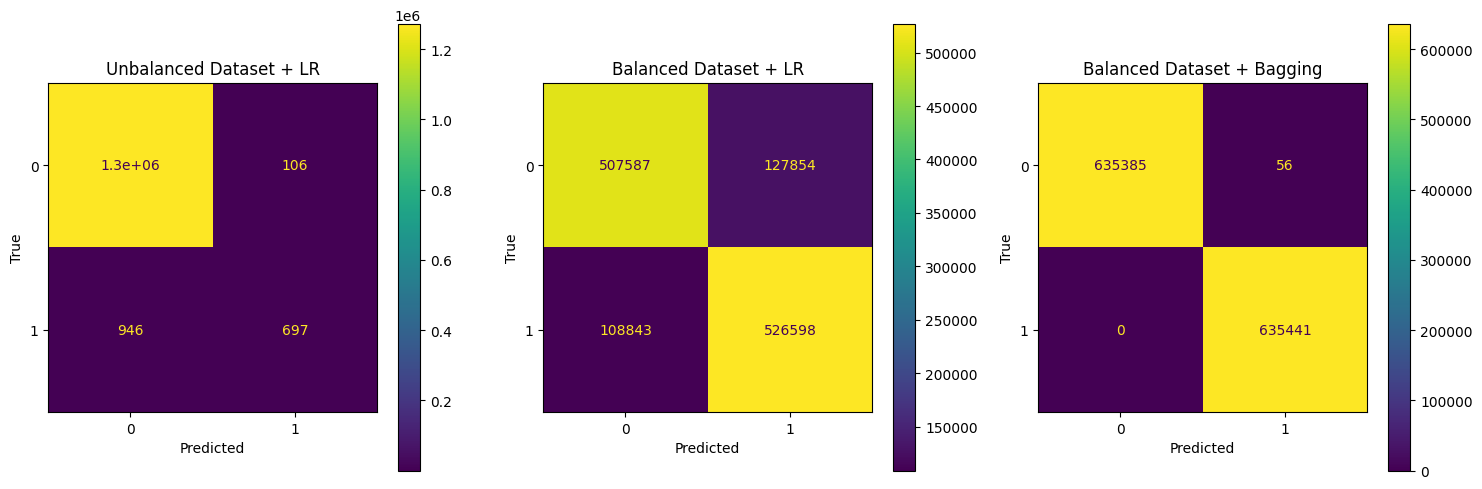

In [98]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#sns.heatmap(cm3, annot=True, cmap='Blues', fmt='d', ax=axes[0])
cm1_disp.plot(ax=axes[0])
axes[0].set_title('Unbalanced Dataset + LR')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')


cm2_disp.plot(ax=axes[1])
axes[1].set_title('Balanced Dataset + LR')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

cm3_disp.plot(ax=axes[2])
axes[2].set_title('Balanced Dataset + Bagging')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()


Below is a summarised comparison of my analysis regards the three experiments using there confusion matrices (CM)

#### 1. Unbalanced Dataset
**Observations**
* The model shows high accuracy, but this is misleading due to the imbalance in the dataset.
* Precision is relatively high, indicating that when the model predicts a positive case, it is usually correct.
* Recall is very low, meaning the model misses a significant number of actual positive cases.
* The F1 score is low, reflecting the poor balance between precision and recall.

#### 2. Balanced Dataset (Resampled)
**Observations**
* Accuracy drops compared to the unbalanced dataset, but this is expected due to the balancing process.
* Precision remains high, indicating good performance in predicting positive cases.
* Recall improves significantly, showing the model is better at identifying actual positive cases.
* The F1 score is much higher, indicating a better balance between precision and recall.


#### 2. Balanced Dataset (Resampled) + Ensemble Bagging
**Observations**
* The model achieves perfect scores across all metrics, indicating an ideal performance.
* This suggests that the ensemble learning approach effectively handles the balanced dataset, eliminating errors in predictions.

### Conclusion
* **Unbalanced Dataset**: High accuracy but poor recall and F1 score due to the imbalance, leading to many missed positive cases.
  
*  **Balanced Dataset (Resampled)**: Improved recall and F1 score, showing better performance in identifying positive cases, though at the cost of slightly lower accuracy.
  
*  **Balanced Dataset (Resampled) + Ensemble Learning**: Perfect performance, indicating that ensemble methods can significantly enhance model performance on balanced datasets.

### Importance of Further Future Work
In the analysis of the three models, we observed varying performance metrics based on the dataset’s balance and the techniques applied. The unbalanced dataset showed high accuracy but poor recall, indicating a significant number of missed positive cases. The balanced resampled dataset improved recall and F1 score, demonstrating better identification of positive cases. The ensemble learning approach on a balanced dataset achieved perfect scores, highlighting its effectiveness.

#### Future Work

1. **GridSearchCV for Hyperparameter Tuning** - Hyper parameters significantly influence the performance of machine learning models. Finding the optimal combination of these parameters can enhance model accuracy, precision, recall, and overall robustness.
   
**Importance**
   * **Performance**: Implementing this technique can greatly improve the robustness of the model, accommodate the change trends in fraud patter or to better generalize the against unseen data.
  
   * **Automation**: The utility allows automation of the tuning/search process, saving time as compared to the manual approach I used earlier

   * **Optimization**: Optimization is key to ensuring that models perform at its best and this can be done by systematically exploring hyper parameters.

**Limitations**
   * **Time Consuming**: The utility takes into account each combination of hyper parameter example when performing cross validation (k-fold cross validation), the model is trained and validated k times for each combination, further multiplying the number of evaluations.
  
   * **Resource constraints**: The utility requires high computational resource, and as a result I could not apply it to my research at the time of developing my model (*although I gave it GO*).

Below I have a sample code with 1 predefined hyper parameter demonstrating how you can use GridSearchCV for future work.



##### Defining Models and Hyperparameter Grids

In [60]:
# Define the models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    
    # I can add as many models as apply to the pipeline
    
    #'GradientBoosting': GradientBoostingClassifier(),
    #'AdaBoost': AdaBoostClassifier(),
}

I define the ensemble models along with their respective hyperparameter grids for tuning.

In [61]:

# Define the hyperparameter grids
param_space = {
    'LogisticRegression': {
       'C': [0.01, 0.1],
       'solver': ['liblinear']
    },
    'RandomForest': {
        'n_estimators': [120],
        'max_depth': [None, 10]
    }
}


In [39]:
# Perform GridSearchCV for each model
best_models = {}
for model in models:
    print(f"Training {model}...")
    grid_search = GridSearchCV(estimator=models[model], param_grid=param_space[model], cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model] = grid_search.best_estimator_
    print(f"Best parameters for {model}: {grid_search.best_params_}")
    



Training LogisticRegression...


KeyboardInterrupt: 

#### Evaluate Results and Select the best model

In [ ]:
# Evaluate the best models on the test set
for model_name in best_models:
    model = best_models[model_name]
    y_pred = model.predict(X_test)
    # if model_name == 'NeuralNetwork':
    #     y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Metrics for {model_name} on test set:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}\n")

In [6]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.
